## **PROPOSAL FOR AIR POLLUTION REGRESSION ANALYSIS**

## Introduction

Air pollution is affected by the weather due to the moisture and the precipitation affecting the concentration of pollutants through factors like humidity, temperature, and particulate matter. 

We’re choosing the air pollutant CO and air particles PM 2.5 because both variables frequently emerge in regards to the air pollution in Beijing, specifically the region Tiantan because of the large population of tourists and locals. We can predict the air condition in the region and the impact it has on the community and how we can further improve it. We want to predict CO and PM 2.5 based on the weather which is decided by 5 variables (the temperature (C°), pressure (hPa), dew point temperature (C°), precipitation (mm), wind speed (m/s)). Questions for this regression analysis includes :
 
1. How does the weather affect the concentration of air particle PM 2.5?
2. How does the weather affect the concentration of gas pollutant CO?

The dataset consists of hourly concentration of air pollutants and meteorological variables from 12 air-monitoring stations in Beijing between March 1, 2013 and February 28, 2017. 

## Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(testthat)
library(digest)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

## Weather Data Set in Tiantan 

In [2]:
weather_data <- read.csv("PRSA_Data_Tiantan_20130301-20170228.csv")
weather_data

No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
1,2013,3,1,0,6,6,4,8,300,81,-0.5,1024.5,-21.4,0,NNW,5.7,Tiantan
2,2013,3,1,1,6,29,5,9,300,80,-0.7,1025.1,-22.1,0,NW,3.9,Tiantan
3,2013,3,1,2,6,6,4,12,300,75,-1.2,1025.3,-24.6,0,NNW,5.3,Tiantan
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35062,2017,2,28,21,18,32,4,48,500,48,10.8,1014.2,-13.3,0,NW,1.1,Tiantan
35063,2017,2,28,22,15,42,5,52,600,44,10.5,1014.4,-12.9,0,NNW,1.2,Tiantan
35064,2017,2,28,23,15,50,5,68,700,21,8.6,1014.1,-15.9,0,NNE,1.3,Tiantan


### Summary Statistics

In [3]:
weather_predictors <- weather_data |> select('TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM') |>
map_dfr(mean, na.rm = TRUE) |> pivot_longer(cols = TEMP:WSPM, names_to = "Predictors", values_to = "Mean")

Standard_Deviation <- weather_data |> select('TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM') |>
map_dfr(sd, na.rm = TRUE) |> pivot_longer(cols = TEMP:WSPM, names_to = "Predictors", values_to = "Standard Deviation") |> pull(2)

NA_Count <- weather_data |> select('TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM') |> 
map_dfr(~sum(is.na(.))) |> pivot_longer(cols = TEMP:WSPM, names_to = "Predictors", values_to = "NA Count") |> pull(2)

summary_statistics <- data.frame(weather_predictors, Standard_Deviation, NA_Count)
summary_statistics


Predictors,Mean,Standard_Deviation,NA_Count
<chr>,<dbl>,<dbl>,<int>
TEMP,1.367149e+01,11.458418,20
PRES,1.012547e+03,10.266059,20
DEWP,2.447535e+00,13.810696,20
RAIN,6.401952e-02,0.786282,20
WSPM,1.860785e+00,1.280368,14


### KNN Regression

In [4]:
tidy_data <- weather_data |> slice(seq(from = 1, to = 33917, by=33)) |>
            select(-No , -year, -month, -day, -hour, -PM10, -SO2, -NO2, -O3, -wd, -PM2.5, -station)|>
            na.omit()

colnames(tidy_data) <-
            c('CO', 'Temperature' , 'Pressure' , 'Dew_Point_Temperature' , 'Rain' , 'Wind_Speed')

tidy_data

,CO,Temperature,Pressure,Dew_Point_Temperature,Rain,Wind_Speed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,300,-0.5,1024.5,-21.4,0,5.7
2,700,0.1,1031.7,-18.1,0,0.5
3,1600,9.9,1014.1,-10.3,0,1.0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1026,700,1.900,1019.7,-10.6,0,4.3
1027,900,1.275,1020.0,-10.3,0,2.7
1028,1600,-4.950,1025.0,-12.1,0,1.2


In [5]:
set.seed(2000) 

weather_split <- initial_split(tidy_data, prop = 0.75, strata = CO)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)


weather_split
weather_training
weather_testing

<Training/Testing/Total>
<744/251/995>

,CO,Temperature,Pressure,Dew_Point_Temperature,Rain,Wind_Speed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,300,-0.5,1024.5,-21.4,0,5.7
8,400,11.3,1020.4,-16.2,0,3.9
21,500,10.7,1017.6,-10.8,0,5.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1020,4100,-5.8,1023.6,-8.5,0,0.9
1021,7200,0.7,1020.9,-4.0,0,0.9
1022,3400,-0.6,1020.8,-9.3,0,0.2


,CO,Temperature,Pressure,Dew_Point_Temperature,Rain,Wind_Speed
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,700,0.1,1031.7,-18.1,0,0.5
6,4200,8.6,999.5,0.1,0,0.6
7,2799,4.0,994.1,-3.5,0,1.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1018,1700,-1.4,1027.7,-13.9,0,4.0
1024,4500,3.5,1026.1,-4.0,0,1.2
1025,4300,2.0,1020.5,-2.9,0,0.8


In [39]:
weather_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
                set_engine("kknn") |>
                set_mode("regression") 

weather_recipe <- recipe(CO ~ Wind_Speed, data = weather_training) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
weather_spec
weather_recipe

K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [40]:
set.seed(1234) 

weather_vfold <- vfold_cv(weather_training, v = 5, strata = CO)

weather_workflow <- workflow() |>
                    add_recipe(weather_recipe) |>
                    add_model(weather_spec)
weather_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [41]:
set.seed(2019)

gridvals <- tibble(neighbors = seq(from = 1, to = 200))

weather_results <- weather_workflow |>
                  tune_grid(resamples = weather_vfold, grid = gridvals) |>
                  collect_metrics()

weather_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,1407.3135998,5,43.278369379,Preprocessor1_Model001
1,rsq,standard,0.0143047,5,0.007447668,Preprocessor1_Model001
2,rmse,standard,1370.0481577,5,32.921288606,Preprocessor1_Model002
⋮,⋮,⋮,⋮,⋮,⋮,⋮
199,rsq,standard,0.1535038,5,0.01044103,Preprocessor1_Model199
200,rmse,standard,1041.8886545,5,45.82895879,Preprocessor1_Model200
200,rsq,standard,0.1530999,5,0.01023006,Preprocessor1_Model200


In [42]:
weather_min <- weather_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |> 
    head(1)

weather_min

k_min <- weather_min |>
          pull(neighbors)

weather_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
          set_engine("kknn") |>
          set_mode("regression")

weather_best_fit <- workflow() |>
          add_recipe(weather_recipe) |>
          add_model(weather_best_spec) |>
          fit(data = weather_training)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
87,rmse,standard,1036.236,5,46.60819,Preprocessor1_Model087


.pred,CO,Temperature,Pressure,Dew_Point_Temperature,Rain,Wind_Speed
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
478.1609,300,-0.5,1024.5,-21.4,0,5.7
651.7126,400,11.3,1020.4,-16.2,0,3.9
478.1609,500,10.7,1017.6,-10.8,0,5.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
1727.586,4100,-5.8,1023.6,-8.5,0,0.9
1727.586,7200,0.7,1020.9,-4.0,0,0.9
1681.586,3400,-0.6,1020.8,-9.3,0,0.2


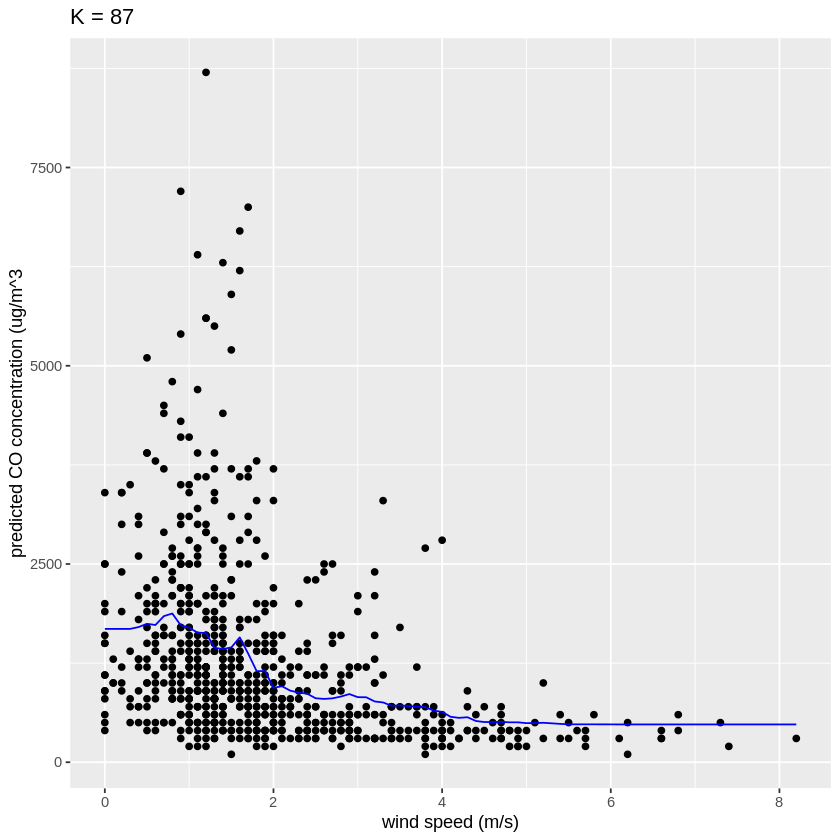

In [43]:
weather_preds <- predict(weather_best_fit, weather_training) |>
bind_cols(weather_training)
weather_preds
weather_plot <- weather_preds |>
ggplot(aes(x=Wind_Speed, y=CO))+
geom_point()+
geom_line(data = weather_preds, 
            mapping = aes(x = Wind_Speed, y = .pred), 
            color = "blue")+
ggtitle(paste0("K = ", k_min)) + 
labs(x="wind speed (m/s)", y= "predicted CO concentration (ug/m^3")
weather_plot

## Methods
We’ll conduct our data analysis with variables as such :

1. Objects for Regression:
- PM 2.5 
- CO

2. Predictors:
- Temperature (TEMP) 
- Pressure (PRES) 
- Dew Point Temperature (DEWP) 
- Rain (RAIN) 
- Wind Speed (WSPM)

3. Variables NOT included within the analysis and why :
- Wind Direction (wd) is categorical therefore is not integrated with the plot. 
- Seasonal weather may influence the prediction, however this is not our topic of study (year, month, day, hour)
- Normalize our data so certain variables with large absolute quantities do not receive undue weight.

We will then perform a KNN regression to analyze the effect that weather has on the concentration of pollutants; we will visualize the results through a regression plot on pollutants (PM 2.5 and CO). We will then create separate regression plots for each predictor in relation to our pollutant.

## Expected outcomes and significance
1. We expect to find a correlation between meteorological conditions with PM 2.5 and CO, while finding differences between the behaviors in different types of air pollutants reacting to different conditions.

2. The relationship between air pollutants and weather conditions may prove the effects of air pollution; helping to advance active pollution reduction technologies or discovering better methods of reducing the penetration of PM 2.5 into households. Also, we may be able to use meteorology combined with behavioral techniques to reduce air pollution.

3. What future questions could this lead to?
- Is the air pollution temporarily reduced or permanently removed from the air through weather events? 
Certain pollutants such as PM 2.5 may be integrated into the environment such as how smoke is washed into the soil and turned into ash.

- How might meteorological conditions be controlled to reduce air pollution in cities? 
Techniques such as rain cloud seeding may be available to reduce the concentration of pollutants during high concentration of pollutants.